#Анализ временных рядов

##Часть первая

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from dateutil.relativedelta import relativedelta

###Визуальный анализ ряда

In [ ]:
data = pd.read_csv("data.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

<ipython-input-485-48507d71819d>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv("data.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)


In [ ]:
data

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


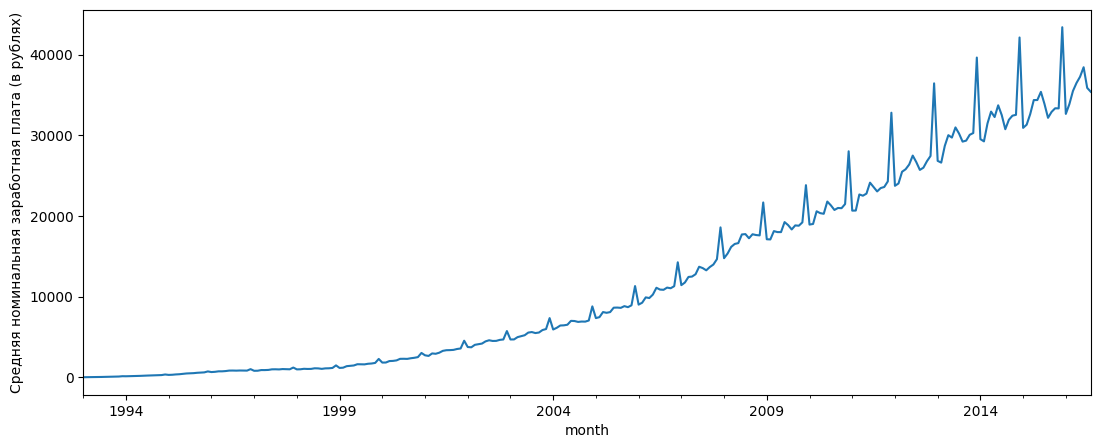

In [ ]:
fig = plt.figure(figsize=(13, 5))
data.WAG_C_M.plot()
plt.ylabel('Средняя номинальная заработная плата (в рублях)')
plt.show() 

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.996491


<Figure size 1300x500 with 0 Axes>

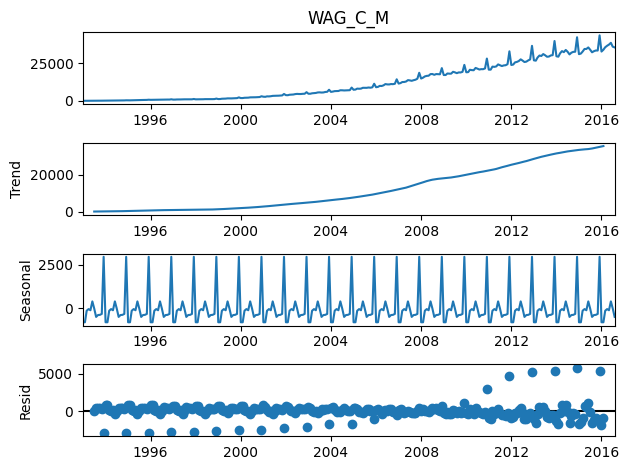

In [ ]:
fig = plt.figure(figsize=(13, 5))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

###Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263044
Критерий Дики-Фуллера: p=0.757007


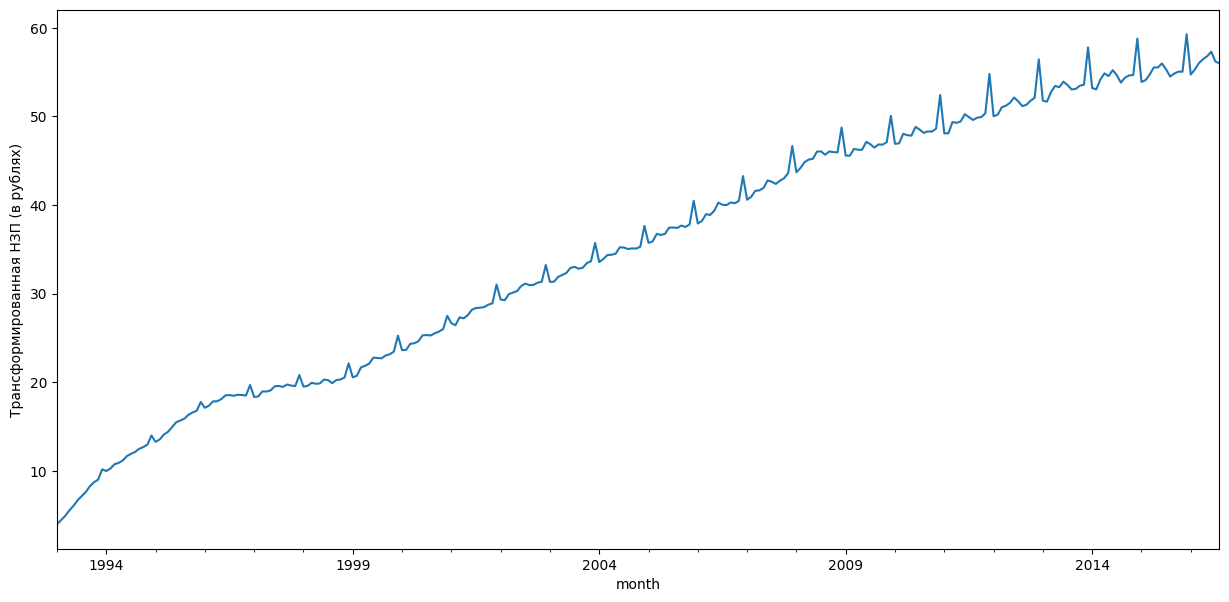

In [ ]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
fig = plt.figure(figsize=(15, 7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Трансформированная НЗП (в рублях)')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

###Выбор порядка дифференцирования

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.007911


<Figure size 1500x1000 with 0 Axes>

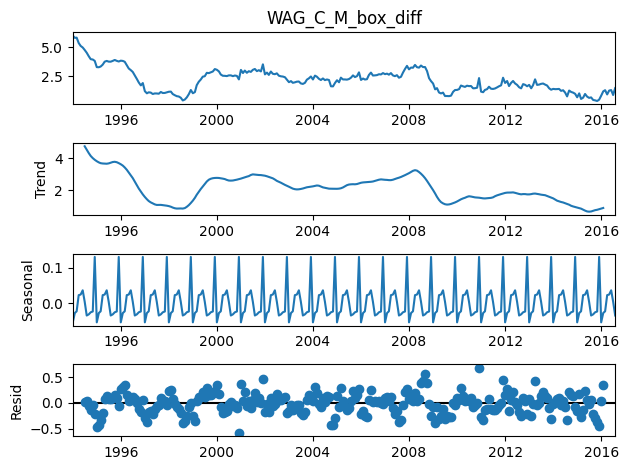

In [ ]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
fig = plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1500x1000 with 0 Axes>

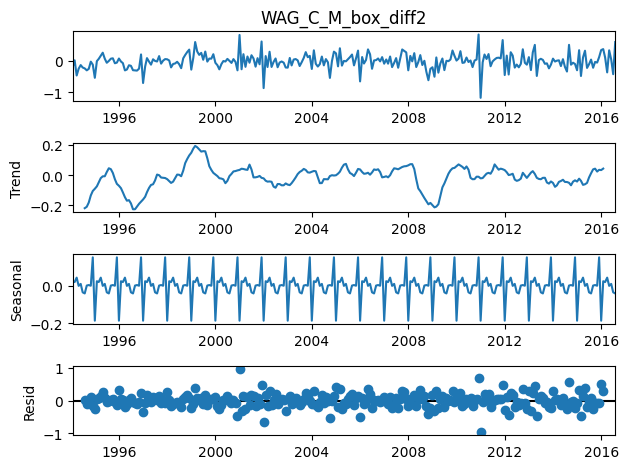

In [ ]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
fig = plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

###Выбор начальных приближений для p, q, P, Q, d

Построим график для автокорреляционной функции

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


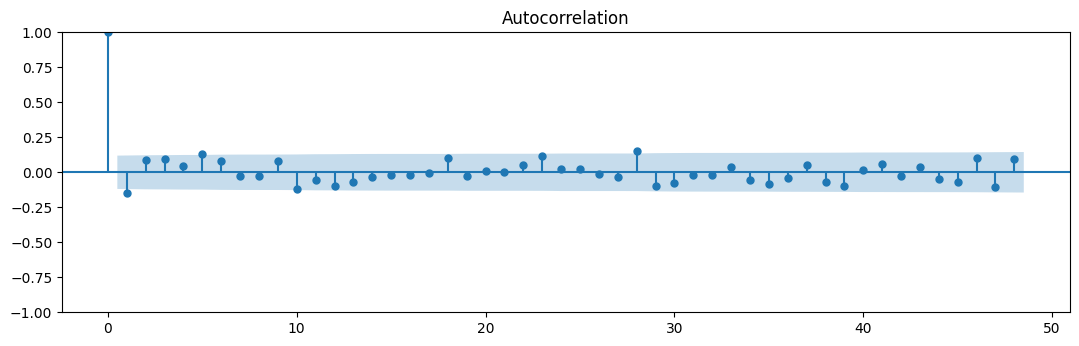

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


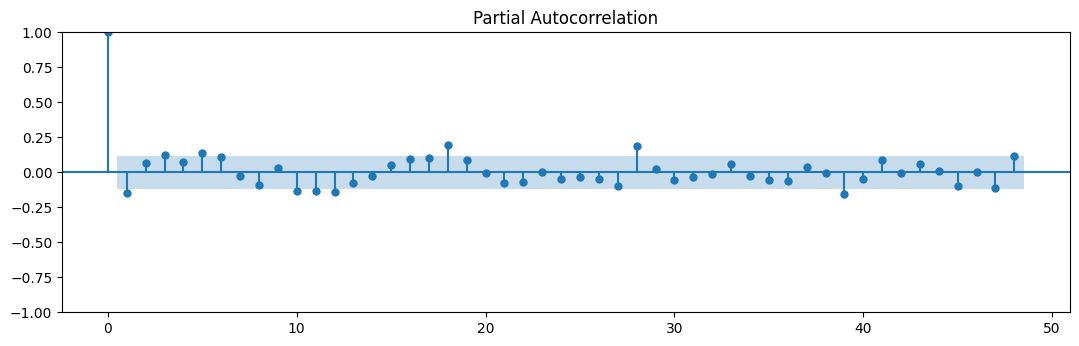

In [ ]:
fig = plt.figure(figsize=(13, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
fig = plt.figure(figsize=(13, 8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

По графику автокорреляционной функции (ACF) определим параметры q и Q:

1) Так как значения коэффициентов автокорреляции на сезонных лагах несущественны (их значения не покидают коридор значимости, обозначенный синим цветом), то параметр Q = 0

2) Так как значения коэффициентов автокорреляции среди первых несезонных лагов значимы только на первом, то параметр q = 1

По графику частичной автокорреляционной функции (PACF) определим параметры p и P:

1) Так как значения коэффициентов автокорреляции на сезонных лагах существенны только при лагах, равными 12 и 48, при этом максимум дастигается на 12 лаге, то параметр P = 1

2) Так как значения коэффициентов автокорреляции среди первых несезонных лагов значимы только на первом, то параметр p = 1

Так как к исходному ряду было применено одно сезонное и одно обычное дифференцирование, то параметры D = 1 и d = 1

Далее значения параметров q, Q, p, P будут определяться перебором (от нуля до установленных значений): из разных значений гиперпараметров выбираются те, у которых значение критерия Акаике будет минимальным.

In [ ]:
qs = range(0, 2)
Qs = range(0, 1)

ps = range(0, 2)
Ps = range(0, 2)

d = 1
D = 1 

Путем перебора параметров p, P, q, Q получим 8 возможных наборов параметров, на каждом из которых обучим модель

In [ ]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

###Обучение и сравнение моделей-кандидатов, выбор победителя

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1.47 s, sys: 1.1 s, total: 2.56 s
Wall time: 1.44 s


Сравним наборы параметров полученных моделей и соответствущие этим наборам коэффициенты Акаике:

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  4.383761
3  (0, 1, 1, 0)  5.428847
7  (1, 1, 1, 0)  6.103035
4  (1, 0, 0, 0)  6.703476
2  (0, 1, 0, 0)  7.652032


Видим, что модель с параметрами p = 1, q = 0, P = 1, Q = 0 лучше всего удовлетворяет критерию Акаике ввиду минимального значения коэффицинта среди других моделей

###Анализ остатков построенной модели

Прежде, чем приступать к прогнозированию с помощью модели, необходимо убедиться в том, что остатки (разница между фактическими значениями и значениями модели) несмещены, стационарны и неавтокоррелированны.

Для оценки несмещенности остатков воспользуемся критерием Стьюдента

Для оценки стационарности остатков восплользуемся критерим Дики-Фуллера

Для оценки неавтокоррелированности воспользуемся критерием Льюнга-Бокса

С помощью метода summury посмотрим на параметры лучшей модели 

In [ ]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   0.808
Date:                            Wed, 17 May 2023   AIC                              4.384
Time:                                    02:17:31   BIC                             15.190
Sample:                                01-01-1993   HQIC                             8.723
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1651      0.046     -3.558      0.000      -0.256      -0.074
ar.S.L12      -0.1332      0.047   

Из блока с информацией об остатках видно, что критерий Льюнга-Бокса имеет уровень значимости 0.99 (Prob(Q)), благодаря чему можем уверенно утверждать, что остатки неавтокоррелированны 

Критерий Стьюдента: p=0.119860
Критерий Дики-Фуллера: p=0.000004


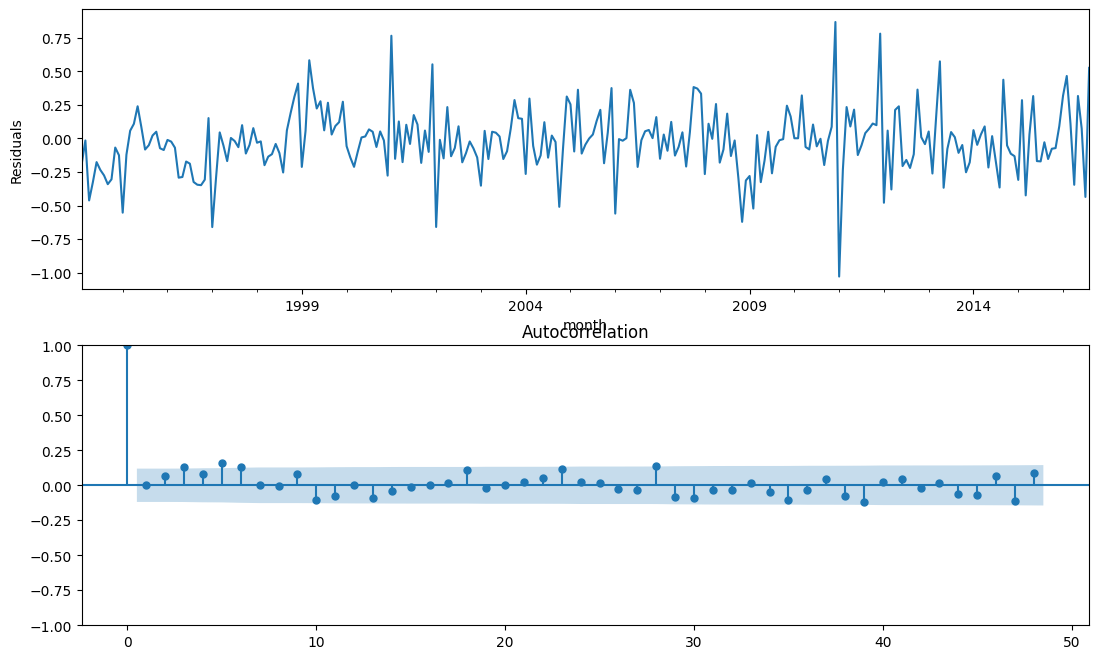

In [ ]:
fig = plt.figure(figsize=(13, 8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает исходные данные:

In [ ]:
def invboxcox(y,lmbda): #Функция для инвертирования функции Бокса-Кокса
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

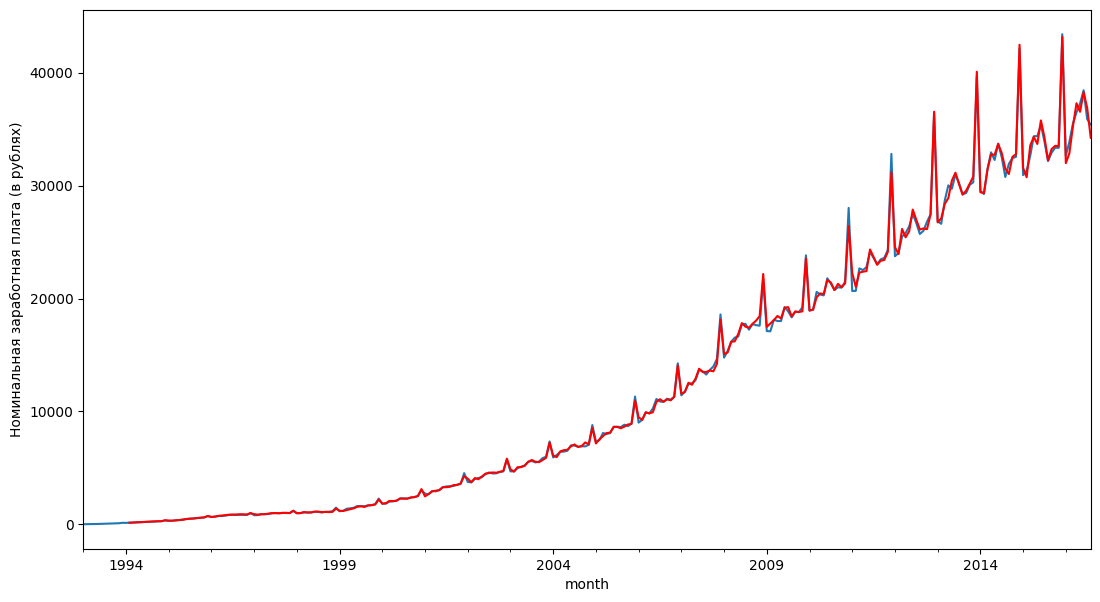

In [ ]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
fig = plt.figure(figsize=(13, 7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Номинальная заработная плата (в рублях)')
plt.show()

###Прогнозирование с помощью финальной модели

Для получения прогноза воспользуемся методом выбранной модели predict и построим исходный ряд (синий цвет), предсказания модели (красный цвет) и реальные данные за прогнозируемый период (зеленый цвет)

<ipython-input-123-2beb6c81b458>:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  real_data = pd.read_csv("real_data.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)


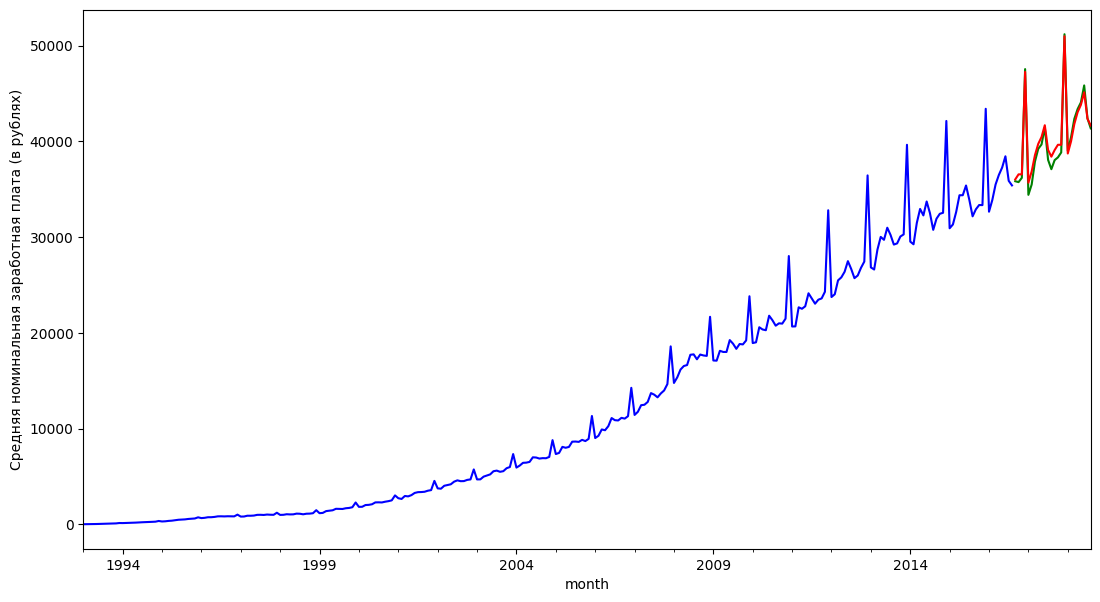

In [ ]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

real_data = pd.read_csv("real_data.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

fig = plt.figure(figsize=(13, 7))
data2.WAG_C_M.plot(color='b')
real_data.WAG_C_M.plot(color='g')
data2.forecast.plot(color='r')
plt.ylabel('Средняя номинальная заработная плата (в рублях)')
plt.show()

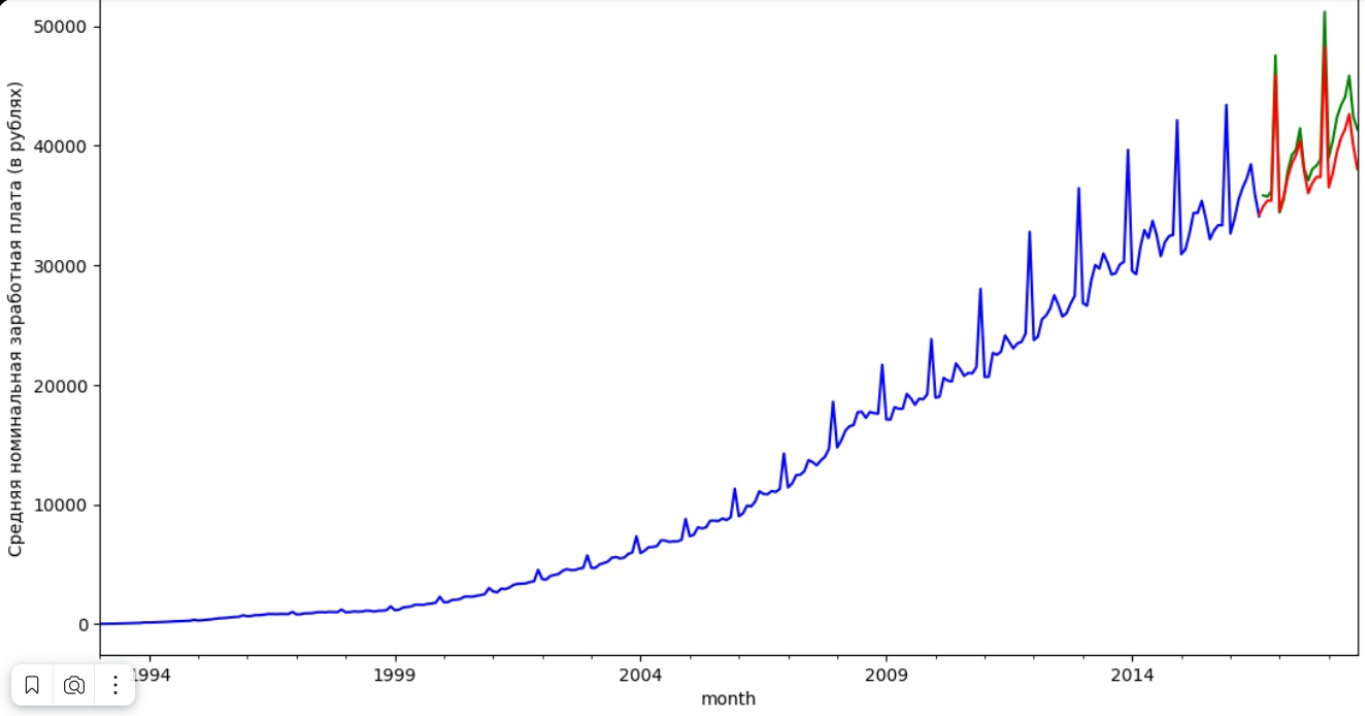

##Часть вторая

In [62]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import MinMaxScaler

In [302]:
# Параметры
window_size = 6 #Размер окна
batch_size = 12 # Размер пакета
shuffle_buffer_size = 500 #

###Подготовка данных

In [133]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)
    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Время")
    plt.ylabel("WAG_C_M")
    plt.grid(True)
    plt.show()

In [134]:
data = pd.read_csv("data.csv", ';')

<ipython-input-134-9c55986b5239>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv("data.csv", ';')


In [135]:
data

,month,WAG_C_M
0,01.01.1993,15.3
1,01.02.1993,19.1
2,01.03.1993,23.6
3,01.04.1993,30.6
4,01.05.1993,37.5
...,...,...
279,01.04.2016,36497.0
280,01.05.2016,37270.0
281,01.06.2016,38447.0
282,01.07.2016,35888.0


In [136]:
test_data = pd.read_csv("real_data.csv", ';')

<ipython-input-136-9cc794951042>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  test_data = pd.read_csv("real_data.csv", ';')


In [137]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  
    # Собираем tensorflow из numpy массива
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Задаем окна заданного размера
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # меняем тип данных окна с Dataset на tensor
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Собираем кортеж из признаков и меток
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # перемешиваем окна
    dataset = dataset.shuffle(shuffle_buffer)
    # Собираем пакеты для обучения
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [138]:
x_train = data['WAG_C_M'].to_numpy()

In [139]:
time_train = np.arange(len(x_train), dtype="float32")

In [140]:
x_test = test_data['WAG_C_M'].to_numpy()

In [141]:
time_test = np.arange(len(x_train), len(x_train) + len(x_test), dtype="float32")

In [142]:
series = np.concatenate([x_train, x_test])

In [143]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [144]:
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 16)
shape of second element: (32,)


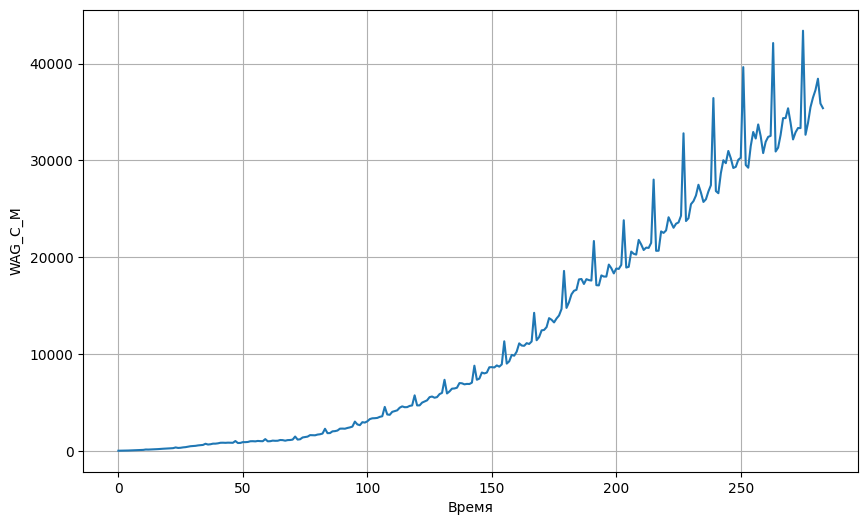

In [145]:
plot_series(time_train, x_train)

###Однослойный перцептрон

Создадим модель однослойной нейронной сети и выведем ее изначальные веса и характеристики

In [20]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

print("Layer weights: \n {} \n".format(l0.get_weights()))

model.summary()

Layer weights: 
 [array([[-0.17552584],
       [-0.6602495 ],
       [-0.36621714],
       [ 0.46655583],
       [ 0.50870085],
       [-0.16750962],
       [-0.1749444 ],
       [ 0.3446684 ],
       [ 0.4790938 ],
       [ 0.14627087],
       [-0.08116233],
       [-0.2675913 ]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


Установим в качестве функции потерь MAE, в качетсве оптимизатора используем stochastic gradient descent (SGD)

In [21]:
model.compile(loss="mae", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

Обучим модель на исходных данных, установив количество эпох = 100

In [22]:
model.fit(dataset,epochs=100)

Epoch 1/100
14/14 [==============================] - 1s 5ms/step - loss: 5779.7793
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 2381.3645
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 1506.3280
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 1554.1726
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 1972.1500
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 1362.9879
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 1502.1233
Epoch 8/100
14/14 [==============================] - 0s 8ms/step - loss: 1182.0731
Epoch 9/100
14/14 [==============================] - 0s 8ms/step - loss: 1199.2512
Epoch 10/100
14/14 [==============================] - 0s 5ms/step - loss: 967.3359
Epoch 11/100
14/14 [==============================] - 0s 3ms/step - loss: 1192.8154
Epoch 12/100
14/14 [==============================] - 0s 6ms/step - loss: 1301.8228
Ep

In [23]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.86401594],
       [-0.34895715],
       [-0.39714566],
       [-0.2744144 ],
       [-0.18607238],
       [-0.05489099],
       [ 0.17615303],
       [ 0.3193538 ],
       [ 0.3439022 ],
       [ 0.3466324 ],
       [ 0.19323564],
       [ 0.12341002]], dtype=float32), array([0.00307994], dtype=float32)]


In [24]:
forecast = x_train

for i in range(len(x_test)):
  forecast = np.append(forecast, model.predict(forecast[-24:][np.newaxis]))

forecast = forecast[-1*len(x_test):]

ValueError: ignored

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[len(x_train) - window_size:]


1/1 [==============================] - 0s 22ms/step


In [ ]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
results

shape after converting to numpy array: (24, 1, 1)
shape after squeezing: (24,)


array([28350.816, 30306.691, 30165.283, 42181.926, 28433.154, 30242.488,
       30095.531, 33108.707, 34056.53 , 34907.598, 32750.455, 30834.666,
       30552.715, 30964.48 , 30392.172, 44834.21 , 29331.498, 30563.068,
       33124.555, 36555.984, 36014.367, 38263.758, 36872.445, 35348.38 ],
      dtype=float32)

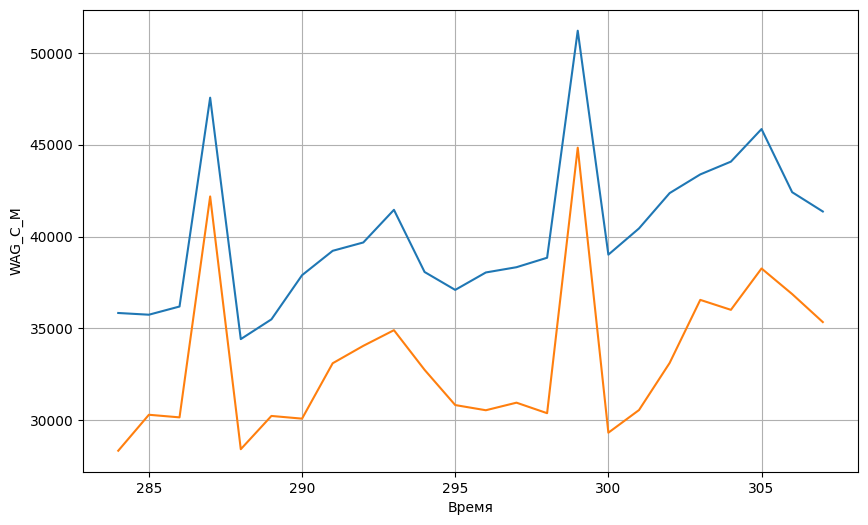

In [ ]:
plot_series(time_test, (x_test, results))

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

5703506.0
1991.727


###RNN

Создадим модель простой RNN и выведем ее свойства

In [212]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_24 (Lambda)          (None, 6, 1)              0         
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 6, 40)             1680      
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_14 (Dense)            (None, 1)                 41        
                                                                 
 lambda_25 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [213]:
data = pd.read_csv('data.csv', ';')

<ipython-input-213-1f18757338a8>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('data.csv', ';')


In [214]:
merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)

<ipython-input-214-1476f55c93e6>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)
<ipython-input-214-1476f55c93e6>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)
<ipython-input-214-1476f55c93e6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)


In [215]:
scaler = MinMaxScaler()
x_scaled =  scaler.fit_transform(np.array(merged_data['WAG_C_M']).reshape(-1, 1))
x_train_scaled = x_scaled[:data.shape[0]].reshape(-1, 1).squeeze()
x_valid_scaled = x_scaled[data.shape[0]:].reshape(-1, 1).squeeze()

Настроим параметры модели. В качестве оптимизатора будем использовать SGD. Для минимизации чувствительности к выбросам будем использовать в качестве функции потерь Huber Loss

In [216]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [217]:
learning_rate = 0.0001

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Устанавливаем параметры для модели
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [218]:
history = model.fit(dataset, epochs=100)

Epoch 1/100
24/24 [==============================] - 2s 7ms/step - loss: 15.4608 - mae: 15.9567
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 2.5411 - mae: 3.0094
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 2.2369 - mae: 2.7013
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 1.3176 - mae: 1.7670
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 0.8612 - mae: 1.2674
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.7091 - mae: 1.1133
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.6795 - mae: 1.0602
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6731 - mae: 1.0751
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 0.7985 - mae: 1.2049
Epoch 10/100
24/24 [==============================] - 0s 5ms/step - loss: 0.4275 - mae: 0.8324
Epoch 11/100
24/24 [==============================] - 0s 

In [219]:
forecast = []

for time in range(len(x_scaled) - window_size):
  forecast.append(model.predict(x_scaled[time:time + window_size][np.newaxis]))

forecast = forecast[len(x_train_scaled) - window_size:]

1/1 [==============================] - 0s 24ms/step


In [220]:
results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

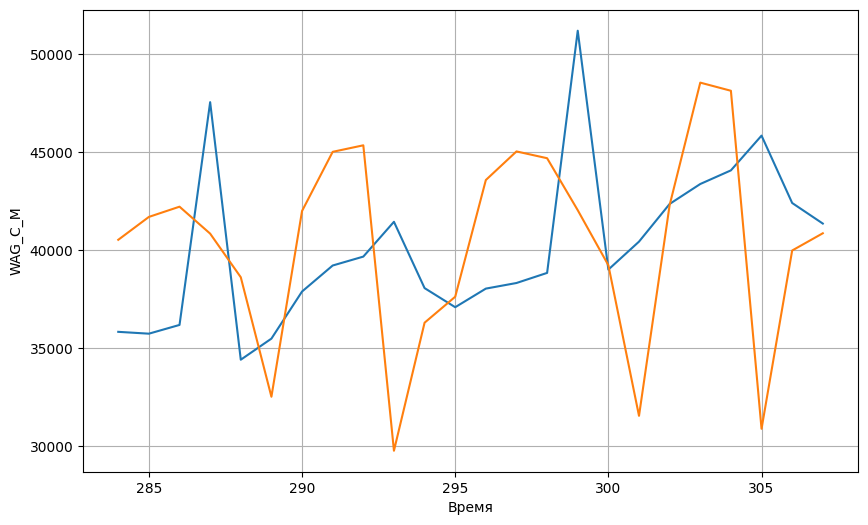

In [221]:
plot_series(time_test, (x_test, results))

In [222]:
print(tf.keras.metrics.mean_squared_error(x_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

38872270.0
5150.0923


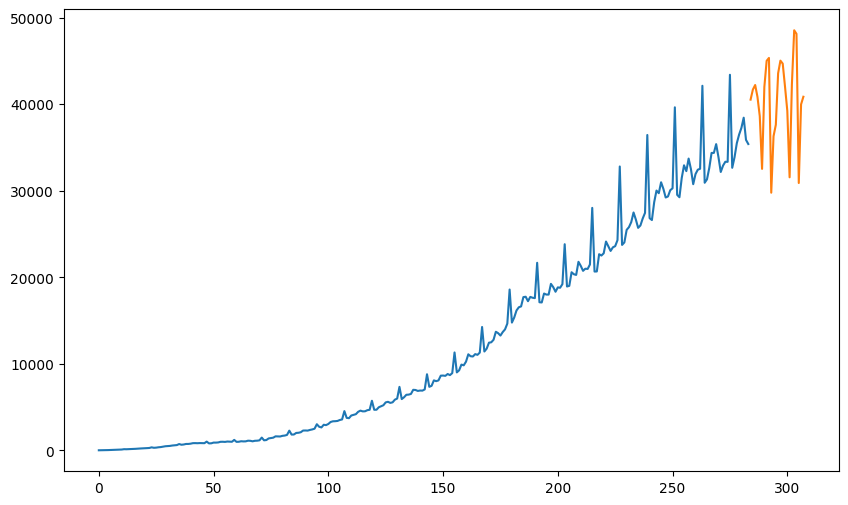

In [223]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data.WAG_C_M)
plt.plot(merged_data.index[-24:], results)
plt.show()

###LSTM

In [263]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 9, 1)              0         
                                                                 
 bidirectional (Bidirectiona  (None, 9, 64)            8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 lambda_2 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

In [264]:
data = pd.read_csv('data.csv', ';')

<ipython-input-264-1f18757338a8>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('data.csv', ';')


In [265]:
merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)

<ipython-input-265-1476f55c93e6>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)
<ipython-input-265-1476f55c93e6>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)
<ipython-input-265-1476f55c93e6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)


In [266]:
scaler = MinMaxScaler()
x_scaled =  scaler.fit_transform(np.array(merged_data['WAG_C_M']).reshape(-1, 1))
x_train_scaled = x_scaled[:data.shape[0]].reshape(-1, 1).squeeze()
x_valid_scaled = x_scaled[data.shape[0]:].reshape(-1, 1).squeeze()

In [267]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [268]:
learning_rate = 0.0001

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Устанавливаем параметры для модели
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [269]:
history = model.fit(dataset, epochs=100)

Epoch 1/100
23/23 [==============================] - 9s 16ms/step - loss: 1.7156 - mae: 2.1916
Epoch 2/100
23/23 [==============================] - 0s 17ms/step - loss: 1.7675 - mae: 2.2539
Epoch 3/100
23/23 [==============================] - 0s 16ms/step - loss: 1.6401 - mae: 2.1401
Epoch 4/100
23/23 [==============================] - 0s 17ms/step - loss: 1.5295 - mae: 2.0288
Epoch 5/100
23/23 [==============================] - 0s 15ms/step - loss: 1.3631 - mae: 1.8428
Epoch 6/100
23/23 [==============================] - 0s 16ms/step - loss: 1.3925 - mae: 1.8914
Epoch 7/100
23/23 [==============================] - 0s 16ms/step - loss: 1.3065 - mae: 1.8065
Epoch 8/100
23/23 [==============================] - 0s 16ms/step - loss: 1.2461 - mae: 1.7450
Epoch 9/100
23/23 [==============================] - 1s 27ms/step - loss: 1.1645 - mae: 1.6645
Epoch 10/100
23/23 [==============================] - 1s 30ms/step - loss: 1.1486 - mae: 1.6478
Epoch 11/100
23/23 [=============================

In [270]:
forecast = []

for time in range(len(x_scaled) - window_size):
  forecast.append(model.predict(x_scaled[time:time + window_size][np.newaxis]))

forecast = forecast[len(x_train_scaled) - window_size:]

1/1 [==============================] - 0s 26ms/step


In [271]:
results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

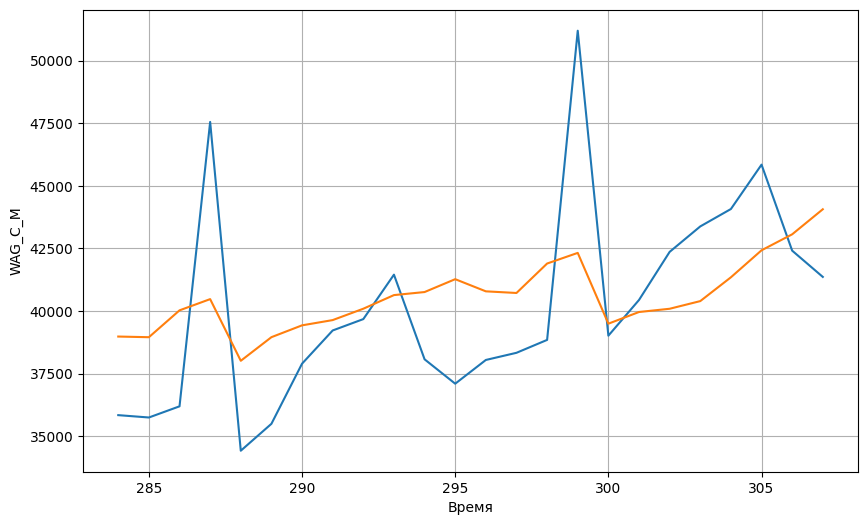

In [272]:
plot_series(time_test, (x_test, results))

In [273]:
print(tf.keras.metrics.mean_squared_error(x_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

11685340.0
2796.5676


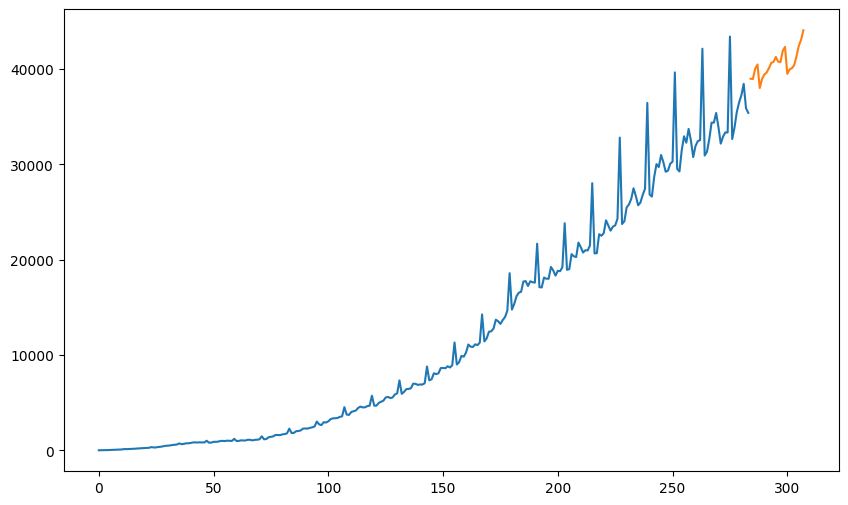

In [274]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data.WAG_C_M)
plt.plot(merged_data.index[-24:], results)
plt.show()

###Conv + LSTM

In [315]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             256       
                                                                 
 lstm (LSTM)                 (None, 6, 64)             33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [316]:
data = pd.read_csv('data.csv', ';')

<ipython-input-316-1f18757338a8>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('data.csv', ';')


In [317]:
merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)

<ipython-input-317-1476f55c93e6>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)
<ipython-input-317-1476f55c93e6>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)
<ipython-input-317-1476f55c93e6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = pd.read_csv('data.csv', ';').append(pd.read_csv('real_data.csv', ';'), ignore_index=True)


In [318]:
scaler = MinMaxScaler()
x_scaled =  scaler.fit_transform(np.array(merged_data['WAG_C_M']).reshape(-1, 1))
x_train_scaled = x_scaled[:data.shape[0]].reshape(-1, 1).squeeze()
x_valid_scaled = x_scaled[data.shape[0]:].reshape(-1, 1).squeeze()

In [319]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [320]:
learning_rate = 0.000001

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Устанавливаем параметры для модели
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [321]:
history = model.fit(dataset, epochs=100)

Epoch 1/100
24/24 [==============================] - 7s 13ms/step - loss: 0.0350 - mae: 0.2035
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0018 - mae: 0.0424
Epoch 3/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0342
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0010 - mae: 0.0299
Epoch 5/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0011 - mae: 0.0307
Epoch 6/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0297
Epoch 7/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0324
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0334
Epoch 9/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0317
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0298
Epoch 11/100
24/24 [=============================

In [322]:
forecast = []

for time in range(len(x_scaled) - window_size):
  forecast.append(model.predict(x_scaled[time:time + window_size][np.newaxis]))

forecast = forecast[len(x_train_scaled) - window_size:]

1/1 [==============================] - 0s 31ms/step


In [323]:
results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

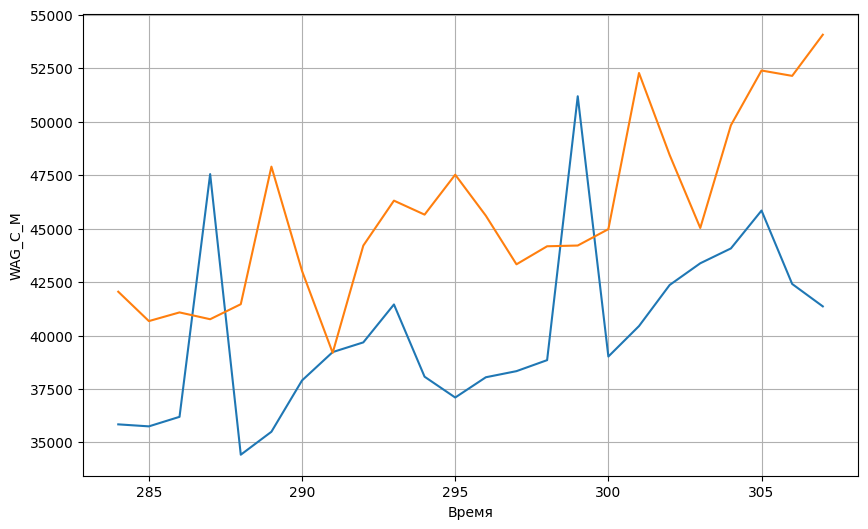

In [324]:
plot_series(time_test, (x_test, results))

In [325]:
print(tf.keras.metrics.mean_squared_error(x_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

53351332.0
6666.7124


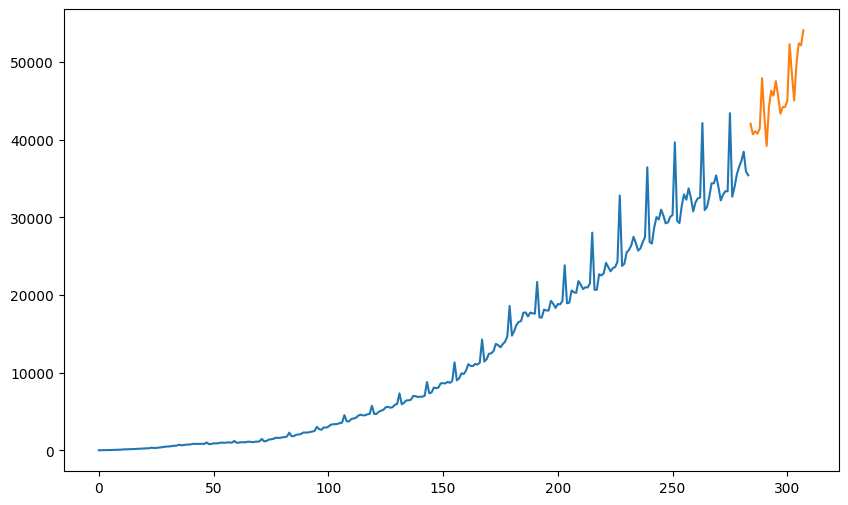

In [326]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data.WAG_C_M)
plt.plot(merged_data.index[-24:], results)
plt.show()